In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
train_ids = pd.read_csv('./fashion-mnist/train/train.csv')
test_ids = pd.read_csv('./fashion-mnist/test/test.csv')

In [3]:
train_ids.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [4]:
class GetData(Dataset):
    def __init__(self, type, root_dir='./') -> None:
        super(Dataset, self).__init__()
        self.type = type

        img_dir = os.path.join(root_dir, f'fashion-mnist/{str(type)}/{str(type)}')

        if os.path.isdir(img_dir):
            images = []

            if type == 'train':
                for id in train_ids['id']:
                    img_path = os.path.join(img_dir, f'{str(id)}.png')
                    img = imread(img_path, as_gray=True)
                    img = np.multiply(img, (1./255.))
                    img = img.astype('float32')
                    images.append(img)
                
                self.x = torch.tensor(images)
                self.y = F.one_hot(torch.tensor(train_ids['label'].values))

            if type == 'test':
                for id in test_ids['id']:
                    img_path = os.path.join(img_dir, f'{str(id)}.png')
                    img = imread(img_path, as_gray=True)
                    img = np.multiply(img, (1./255.))
                    img = img.astype('float32')
                    images.append(img)
                
                self.x = torch.tensor(images)


        else:
            raise OSError('parameter "type" must be either train or test')        
    
    def __getitem__(self, index):
        if self.type == 'train':
            return self.x[index], self.y[index]
        elif self.type == 'test': 
            return self.x[index]
        
    def __len__(self):
        return self.x.shape[0]

In [5]:
train_set = GetData('train')

C:\Users\ASC_Student\AppData\Local\Temp\ipykernel_18964\1640119489.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  self.x = torch.tensor(images)


In [6]:
train_set.x.shape

torch.Size([60000, 28, 28])

In [7]:
train_set.y.shape

torch.Size([60000, 10])

In [8]:
test_set = GetData('test')
test_set.x.shape

torch.Size([10000, 28, 28])

In [9]:
dl = DataLoader(train_set, batch_size=10)
print(f'Num data batches = {len(dl)}')
for x, y in dl:
    print(x.shape)
    print(y.shape)
    break

Num data batches = 6000
torch.Size([10, 28, 28])
torch.Size([10, 10])


In [10]:
class ConvNet(nn.Sequential):
    def __init__(self) -> None:
        super(nn.Sequential, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3, 3), padding='same'), 
            nn.MaxPool2d(kernel_size=(3, 3), stride=1), 
            nn.ReLU(),
            nn.Conv2d(4, 16, kernel_size=(3, 3), stride=2),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1),
            nn.ReLU(), 
            nn.Flatten(),
            nn.Linear(1600, 800), 
            nn.ReLU(),
            nn.Linear(800, 10)
        )
    
    def forward(self, x):
        batch_len = x.shape[0]
        x = x.view(batch_len, 1, 28, 28)        
        return self.forward_pass(x).squeeze()

In [11]:
net = ConvNet()

In [13]:
def plot_images(*images):
    fig, axs = plt.subplots(1, len(images))

    if len(images) != 1:
        for i in range(len(images)):
            axs[i].imshow(images[i])
            axs[i].grid(False)
            axs[i].axis('off')
    else:
        axs.imshow(images[0])
        axs.grid(False)
        axs.axis('off')

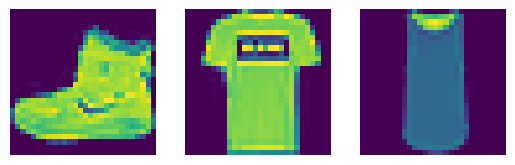

In [14]:
xs, ys = train_set[0:3]
test_imgs = xs.view(3, 1, 28, 28)
plot_images(test_imgs[0].squeeze(), test_imgs[1].squeeze(), test_imgs[2].squeeze())
# test_imgs[0].squeeze().shape

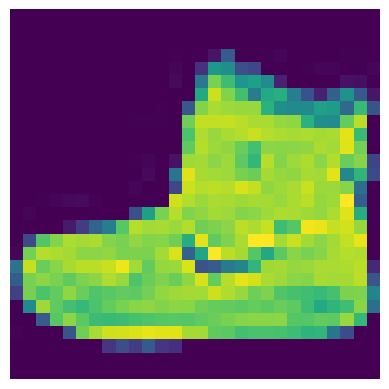

In [15]:
plot_images(train_set[0][0])

In [16]:
xs, ys = train_set[0:3]
net(xs)

tensor([[-0.0385, -0.0082,  0.0186,  0.0215, -0.0284, -0.0345,  0.0219,  0.0035,
         -0.0338, -0.0109],
        [-0.0385, -0.0082,  0.0186,  0.0215, -0.0284, -0.0345,  0.0219,  0.0035,
         -0.0338, -0.0109],
        [-0.0385, -0.0082,  0.0186,  0.0215, -0.0284, -0.0345,  0.0219,  0.0035,
         -0.0338, -0.0109]], grad_fn=<SqueezeBackward0>)

In [17]:
xs.shape

torch.Size([3, 28, 28])

In [18]:
xs.shape[0]

3

In [19]:
loss = nn.CrossEntropyLoss()
loss(net(xs).float(), ys.float())

tensor(2.3233, grad_fn=<DivBackward1>)

In [38]:
def train(dl, network, epochs):
    optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    training_data = {"epochs": [], "losses": [], "epoch-loss": []}
    for epoch in range(epochs):
        num_batches = len(dl)

        curr_epoch_losses = []
        for j, (x, y) in enumerate((dl)):
            optimizer.zero_grad()
            
            curr_loss = criterion(network(x).float(), y.float())            
            curr_loss.backward()
            optimizer.step()
            print(f'DEBUGGING: Current gradient: {network.forward_pass.grad}')

            training_data["epochs"].append(epoch + (j / num_batches))
            training_data["losses"].append(curr_loss.item())
            curr_epoch_losses.append(curr_loss.item())

        training_data["epoch-loss"].append(np.mean(np.asarray(curr_epoch_losses)).item())

        print(f'Epoch #{(epoch + 1)}/{epochs} - Loss: {training_data["epoch-loss"][-1]}')
    
    return training_data

In [39]:
training_data = train(dl, net, epochs=5)

AttributeError: 'Sequential' object has no attribute 'grad'